In [2]:
import zipfile

from PIL import Image
import pytesseract
import cv2 as cv
import numpy as np
import re
from IPython.display import display

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

# the rest is up to you!

# Define a global page list, we will fill that later with dictionaries, containing all needed information
newspaper_pages = []

def openImageZipFile(filename):
    '''
    This function will open a zip file containing images. It returns a list of dictionaries, which will contain the
    file names, as well as PIL Image objects, containing the image data. Non-image files in the zip file will
    be ignored
    
    :param filename: the filename of a Zip File
    :return imagelist: a list of dictionaries, where the key "filename" contains the filename and the
    key "image" contains a PIL image object
    '''
    imagelist = []

    try:
        with zipfile.ZipFile(filename) as myZip:
            for item in myZip.infolist():
                with myZip.open(item) as file:
                    try:
                        image = Image.open(file)
                        image.load()
                        imagelist.append({"filename": item.filename, "image":image})
                        print("Loaded image {} from zipfile {}".format(item.filename, filename))
                    except IOError:
                        print("Ignoring file")
                        continue
    except:
        print("Zipfile {} not found".format(filename))
                        
    return imagelist


def addWordListFromImages(imagelist):
    '''
    This function runs OCR using tesseract on the images in imagelist. Imagelist will be modified, each item will 
    afterwards have a key "words" containing all the words found in the page. We do not need to take care of any word
    order or anything. All words will be lower-cased. The word list will only contain unique words.
    
    :param imagelist: A list of dictionaries, where the key "image" will contain the PIL Image data to process    
    '''
    for item in imagelist:
        text = pytesseract.image_to_string(item["image"].convert("1")).lower()
        all_words = re.compile('\w+').findall(text)
        unique_words = []
        for word in all_words:
            if word not in unique_words:
                unique_words.append(word)
        item["words"] = unique_words
        print("Ran OCR on image {} and found {} unique words".format(item["filename"], len(unique_words)))

def detectFacesInImages(imagelist, scale):
    '''
    This function runs a face detection using OpenCV on the images in imagelist. Imagelist will be modified, each item will 
    afterwards have a key "faces" containing the bounding boxes of the faces detected in that image.
    
    :param imagelist: A list of dictionaries, where the key "image" will contain the PIL Image data to process   
    :param scale: The scale factor to apply for face detection
    '''
    for item in imagelist:
        faces = face_cascade.detectMultiScale(np.array(item["image"].convert("L")), scale, 5)
        item["faces"] = faces
        print("Ran Face Detection on image {} and found {} faces".format(item["filename"], len(faces)))

def extractFaceImages(imagelist, thumb_size):
    '''
    This function extracts previously detected faces from an image. There must be a key "faces" in the dictionary.
    
    :param imagelist: A list of dictionaries, where the key "image" will contain the PIL Image data to process    
    '''
    for item in imagelist:
        face_images = []
        for rec in item["faces"]:
            # Extract image
            face_images.append(item["image"].crop((rec[0],rec[1],rec[0]+rec[2],rec[1]+rec[3])))
        # resize to thumbnails
        for face in face_images:
            face.thumbnail(thumb_size)
        # And display
        item["face_images"] = face_images

def createContactSheet(images, size=(100,100), columns=5):
    '''
    This function creates a contact sheet from the given image list, resizing the images to thumbnails, displaying
    the images in given number of columns
    
    :param images: A list of Image object to display
    :param size: A tuple defining maximum size for the thumbnails
    :param columns: Number of columns for the images (rows will be calculated)
    :return contact_sheet_image The newly created contact sheet
    '''
    
    t_width, t_height = size
    # Calculate rows and columns
    columns = 5
    rows = int(len(images) / columns + 1)
    
    # determine size of contact sheet
    c_width = columns * t_width
    c_height = rows * t_height
    
    thumbnails = []
    
    # resize to thumbnails, use copies
    for im in images:
        im_cpy = im.copy()
        im_cpy.thumbnail(size)
        thumbnails.append(im_cpy)

    contact_sheet = Image.new("RGB", (c_width, c_height))
    
    # paste images into contact sheet
    r = 0
    c = 0
    for im in thumbnails:
        # paste at current position
        contact_sheet.paste(im, (c*t_width, r*t_height))
        # update position
        c += 1
        if c >= columns:
            c = 0
            r += 1
            
    return contact_sheet

def searchImages(term, imagelist):
    '''
    This function runs a search on imagelist. It will look for the term in each images and display a contact
    sheet with all detected faces (if any).
    
    :param term: The word to search for
    :param imagelist: A list of dictionaries, where the key "image" will contain the PIL Image data to process   
    '''
    
    for item in imagelist:
        if term.lower() in item["words"]:
            print("Results found in file {}".format(item["filename"]))
            if len(item["face_images"]) > 0:
                # display contact sheet
                cs = createContactSheet(item["face_images"])
                display(cs)
            else:
                print("But there were no faces in that file!")



In [2]:
# Now run everything on the small images
newspaper_pages_sm = openImageZipFile("readonly/small_img.zip")
addWordListFromImages(newspaper_pages_sm)

Loaded image a-0.png from zipfile readonly/small_img.zip
Loaded image a-1.png from zipfile readonly/small_img.zip
Loaded image a-2.png from zipfile readonly/small_img.zip
Loaded image a-3.png from zipfile readonly/small_img.zip
Ran OCR on image a-0.png and found 509 unique words
Ran OCR on image a-1.png and found 892 unique words
Ran OCR on image a-2.png and found 1197 unique words
Ran OCR on image a-3.png and found 1555 unique words


In [9]:
detectFacesInImages(newspaper_pages_sm, 1.3)

Ran Face Detection on image a-0.png and found 6 faces
Ran Face Detection on image a-1.png and found 5 faces
Ran Face Detection on image a-2.png and found 2 faces
Ran Face Detection on image a-3.png and found 2 faces


In [10]:
extractFaceImages(newspaper_pages_sm, (100,100))

Results found in file a-0.png


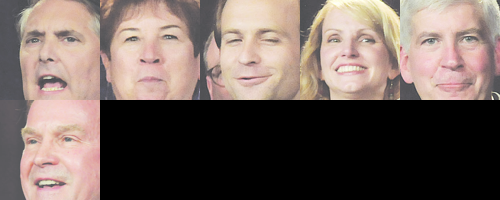

Results found in file a-3.png


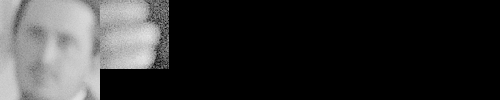

In [11]:
searchImages("Christopher", newspaper_pages_sm) 

In [3]:
# Run everything on large images
newspaper_pages = openImageZipFile("readonly/images.zip")
addWordListFromImages(newspaper_pages)

Loaded image a-0.png from zipfile readonly/images.zip
Loaded image a-1.png from zipfile readonly/images.zip
Loaded image a-10.png from zipfile readonly/images.zip
Loaded image a-11.png from zipfile readonly/images.zip
Loaded image a-12.png from zipfile readonly/images.zip
Loaded image a-13.png from zipfile readonly/images.zip
Loaded image a-2.png from zipfile readonly/images.zip
Loaded image a-3.png from zipfile readonly/images.zip
Loaded image a-4.png from zipfile readonly/images.zip
Loaded image a-5.png from zipfile readonly/images.zip
Loaded image a-6.png from zipfile readonly/images.zip
Loaded image a-7.png from zipfile readonly/images.zip
Loaded image a-8.png from zipfile readonly/images.zip
Loaded image a-9.png from zipfile readonly/images.zip
Ran OCR on image a-0.png and found 509 unique words
Ran OCR on image a-1.png and found 892 unique words
Ran OCR on image a-10.png and found 934 unique words
Ran OCR on image a-11.png and found 646 unique words
Ran OCR on image a-12.png and 

In [4]:
detectFacesInImages(newspaper_pages, 1.3)

Ran Face Detection on image a-0.png and found 6 faces
Ran Face Detection on image a-1.png and found 5 faces
Ran Face Detection on image a-10.png and found 0 faces
Ran Face Detection on image a-11.png and found 0 faces
Ran Face Detection on image a-12.png and found 0 faces
Ran Face Detection on image a-13.png and found 1 faces
Ran Face Detection on image a-2.png and found 2 faces
Ran Face Detection on image a-3.png and found 2 faces
Ran Face Detection on image a-4.png and found 0 faces
Ran Face Detection on image a-5.png and found 6 faces
Ran Face Detection on image a-6.png and found 3 faces
Ran Face Detection on image a-7.png and found 0 faces
Ran Face Detection on image a-8.png and found 0 faces
Ran Face Detection on image a-9.png and found 1 faces


In [5]:
extractFaceImages(newspaper_pages, (100,100))

Results found in file a-0.png


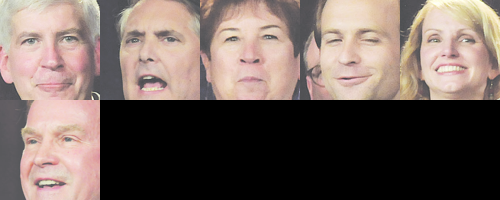

Results found in file a-1.png


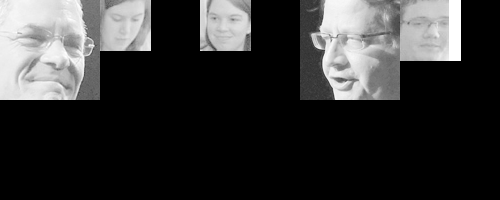

Results found in file a-10.png
But there were no faces in that file!
Results found in file a-13.png


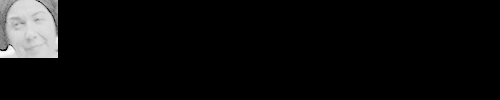

Results found in file a-2.png


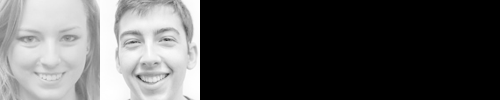

Results found in file a-3.png


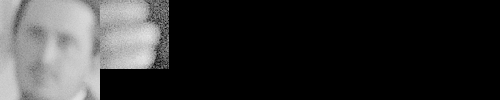

Results found in file a-5.png


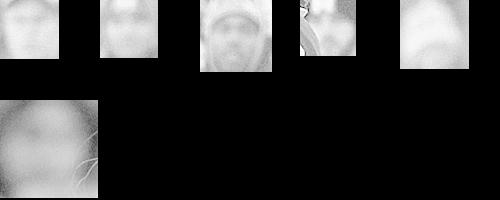

Results found in file a-8.png
But there were no faces in that file!
Results found in file a-9.png


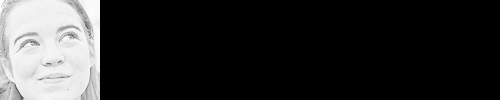

In [6]:
searchImages("Mark", newspaper_pages)